In [2]:
include("butterfly_lfs_auxiliary.jl")
original_sample_file_path = "paper_data/butterfly_points_lfs_sparse.csv"
lfs_file_path = "paper_data/local_feature_sizes.csv"
lean_axis_path = "paper_data/lean_medial_axis.csv"

"paper_data/lean_medial_axis.csv"

In [3]:
using JLD, Measures
PersistenceDiagramsBase = PersistenceDiagrams

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/home/parker/.julia/packages/Plots/hyS17/src/backends/hdf5.jl", 162, UndefVarError(:HDF5Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f9761b3d843, Ptr{Nothing} @0x00007f9761bca17c, Ptr{Nothing} @0x00007f9761bca73b, Ptr{Nothing} @0x00007f9761bca389, Ptr{Nothing} @0x00007f9761bca8f0, Ptr{Nothing} @0x00007f9761bcb9c8, Ptr{Nothing} @0x00007f9761bcc616, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x00007f9761be4e08, Ptr{Nothing} @0x00007f9761be578e, Ptr{Nothing} @0x00007f9761be513a, Ptr{Nothing} @0x00007f9761be53c8, Ptr{Nothing} @0x00007f9761bc0105, Ptr{Nothing} @0x00007f9761be615d, Ptr{Nothing} @0x00007f97531cf4bb, Ptr{Nothing} @0x00007f97280f8e1c, Ptr{Nothing} @0x00007f9761bca75b, Ptr{Nothing} @0x00007f9761bca389, Ptr{Nothing} @0x00007f9761bca8f0, Ptr{Nothing} @0x00007f9761bcb9c8, Ptr{Nothing} @0x00007f9761bcc616, Base.InterpreterIP i

PersistenceDiagrams

In [4]:
@load "paper_data/standard_wfs_results.jld"
@load "paper_data/lfs_baseline_results.jld"
@load "paper_data/lean_wfs_results.jld"

1-element Array{Symbol,1}:
 :lean_wfs_results

In [57]:
ticks = standard_wfs_results["ticks"]
every_other_tick = every_other(ticks,20)
pop!(every_other_tick)
push!(every_other_tick,round(ticks[end],digits=1))

10-element Array{Float64,1}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 1.0

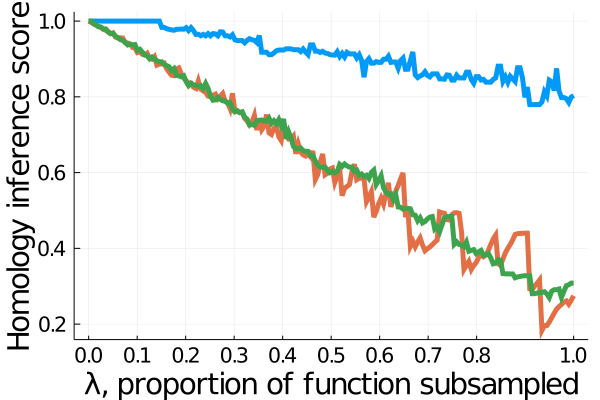

In [58]:
using Plots
all_scores = hcat(scores_from_results(standard_wfs_results), scores_from_results(lfs_baseline_results), scores_from_results(lean_wfs_results))
plot(ticks,all_scores,xguidefontsize=20,yguidefontsize=20,xticks=every_other_tick,xlab="λ, proportion of function subsampled",ylab="Homology inference score",linewidth=5,legend=false,tickfontsize=14,labels=["wfs" "lfs" "lnfs"])


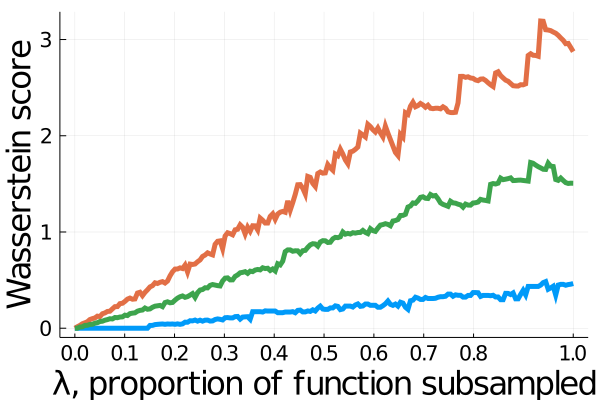

In [49]:
#all_wasserstein = hcat(wasserstein_scores_from_results(standard_wfs_results), wasserstein_scores_from_results(lfs_baseline_results), wasserstein_scores_from_results(lean_wfs_results))
@load "paper_data/wasserstein_scores.jld"
all_empty_wfs = [dist_to_empty(standard_wfs_results["persistence_diagrams"][1]),dist_to_empty(lfs_baseline_results["persistence_diagrams"][1]),dist_to_empty(lean_wfs_results["persistence_diagrams"][1])]
for i in 1:3
    all_wasserstein[:,i] = all_wasserstein[:,i]/all_empty_wfs[i]
end
plot(ticks,all_wasserstein,xguidefontsize=22,yguidefontsize=22,xticks=every_other_tick,xlab="λ, proportion of function subsampled",ylab="Wasserstein score",linewidth=5,legend=false,tickfontsize=14,labels=["wfs" "lfs" "lnfs"])

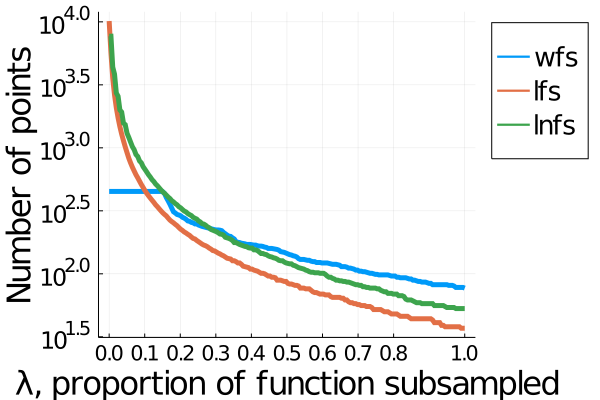

In [59]:
all_lengths = hcat(number_of_points_from_results(standard_wfs_results), number_of_points_from_results(lfs_baseline_results), number_of_points_from_results(lean_wfs_results))
plot(ticks,all_lengths,xticks=every_other_tick,xlab="λ, proportion of function subsampled",ylab="Number of points",xguidefontsize=22,yguidefontsize=22,legendfontsize=18,linewidth=5,legend=:outertopright,xtickfontsize=14,ytickfontsize=16,labels=["wfs" "lfs" "lnfs"],yaxis=:log)
#plot(ticks,all_lengths,xticks=every_other_tick,xlab="λ, proportion of feature size subsampled",ylab="Number of points in sample",linewidth=5,legend=:outertopright,tickfontsize=6,labels=["wfs" "lfs" "lnfs"],ylim=[0,250])


In [5]:
using CSV, DataFrames
original_sample = CSV.read(original_sample_file_path,DataFrame,header=false)
original_sample = values.(eachrow(original_sample))
original_sample = [[original_sample[i][1],original_sample[i][2],i] for i in 1:length(original_sample)]
local_feature_sizes = CSV.read(lfs_file_path,DataFrame,header=false)
local_feature_sizes = values.(eachcol(local_feature_sizes))
local_feature_sizes = [entry[1] for entry in local_feature_sizes]
function lfs_return(point) 
    return local_feature_sizes[Int(point[3])]
end
function modified_norm(point) 
    return norm((point[1],point[2]))
end
lfs_family = function(proportion)
    return function(point)
        proportion*lfs_return(point)
    end
end
sparsified_sample_with_indices = subsample_with_function(original_sample,lfs_family(0.75),modified_norm;has_index=true)

lean_medial_axis = CSV.read(lean_axis_path,DataFrame,header=false)
lean_medial_axis = values.(eachrow(lean_medial_axis))
lean_axis_tree = KDTree([tup[k] for k in 1:2,tup in lean_medial_axis])
lean_axis_family = function(proportion)
    dist_func, _ = distance_to_lean_medial_axis([];mu=proportion,lean_axis=lean_axis_tree)
    return dist_func
end
lean_transform = function(points) return modified_lean_matrix(points,lean_axis_tree) end
lean_sparsified_sample = subsample_with_function([[sample[1],sample[2]] for sample in original_sample],lean_axis_family(nothing))
new_lean_sparsified_sample = subsample_with_function(lean_sparsified_sample,lean_axis_family(0.25))



264-element Array{Array{Float64,1},1}:
 [0.4035489441866095, 2.0338288667414064]
 [2.561311602274655, 1.210318167235929]
 [-0.5432636417416715, 2.037208837155478]
 [-0.08276337703170561, 1.94529909773685]
 [2.3651482447383563, 0.7929413185727574]
 [2.462749287027261, 0.9998407627479411]
 [1.167958771312347, 2.387438825877175]
 [-2.545449477411132, 1.474705392721579]
 [2.655080679084679, 1.4189288098215842]
 [0.18106328529164023, 1.9710095003007932]
 [-0.2983776312457858, 1.9686760479228775]
 [0.6212893897423122, 2.1208454272342223]
 [-0.749642028826607, 2.1190210917387615]
 ⋮
 [-1.8273916093258553, -1.6263255383076487]
 [-1.9036016707440362, -1.549265041293939]
 [-1.8992955104580886, -1.560465612707934]
 [-1.89332870087142, -1.5727409864293325]
 [-1.8395736651737902, -1.6220263290780346]
 [-1.8873960667530185, -1.5824990600097069]
 [-1.8489432992212826, -1.6175856984921833]
 [-1.8817556989365487, -1.5901923817890165]
 [-1.8566636834000205, -1.6130319308213417]
 [-1.8762661725864038, -1

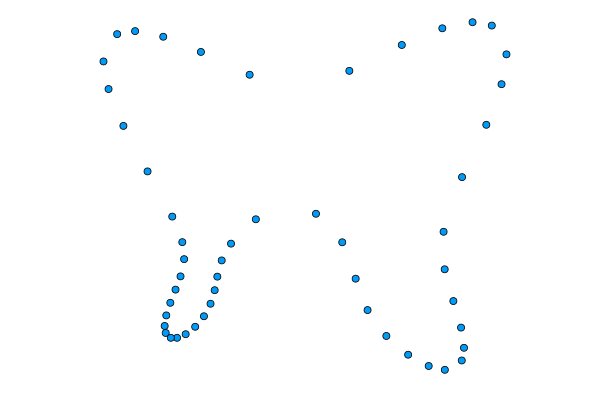

In [11]:
using Plots
xpts = [sample[1] for sample in sparsified_sample_with_indices]
ypts = [sample[2] for sample in sparsified_sample_with_indices]
scatter(xpts,ypts,axis=([], false),legend=false,aspect_ratio=:equal)

In [ ]:
xpts = [sample[1] for sample in new_lean_sparsified_sample]
ypts = [sample[2] for sample in new_lean_sparsified_sample]
l_xpts = [sample[1] for sample in lean_medial_axis]
l_ypts = [sample[2] for sample in lean_medial_axis]
scatter(xpts,ypts, legend=false, axis=([], false),aspect_ratio=:equal)
scatter!(l_xpts,l_ypts,aspect_ratio=:equal)

In [ ]:
# Lower and upper bounds
a = 0.011152204408817637
MK = 1.0000000015936255^2
MKhat = 1.0000000015936257
up_a = 2*MK^2*MKhat*a
using Ripserer
#pd = ripserer(modded_distance,threshold=up_a*2.0,dim_max=1)
pd = ripserer(modded_distance,dim_max=1)